In [4]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt, multiprocessing as mp
from numpy import random
import torch, cv2, time, random, os, threading, pickle

In [5]:
DTYPE = {
    'boolean': torch.bool, 'ui8': torch.uint8, 'i8': torch.int8, 'i16': torch.int16, 'i32': torch.int32, 'i64': torch.int64, 
    'f16': torch.float16, 'f32': torch.float32, 'f64': torch.float64, 'f64Complex': torch.complex64, 'f128Complex': torch.complex128
}
DEVICE = {
    'auto': torch.device("cuda:0" if torch.cuda.is_available() else "cpu"), 
    'cpu': torch.device('cpu'), 
    'cuda0': torch.device('cuda:0')
}

DEVICE_CHOICE = 'auto'

In [6]:
def watch(x, area, startPoint):
    rowImg, columnImg, depthImg = x.shape
    rowVision, columnVision = area
    startX, startY = startPoint
    totalCanvas = np.zeros((rowImg+rowVision*2, columnImg+columnVision*2, depthImg), dtype=np.int)
    totalCanvas[rowVision:rowVision+rowImg,columnVision:columnVision+columnImg] = x
    seeing = totalCanvas[startX:startX+rowVision+1, startY:startY+columnVision+1]
    return seeing

In [7]:
def addNoise(x, volumn = 50):
    row, column, depth = x.shape
    noise = np.random.randint(low=-volumn, high=volumn, size=(row, column, depth))
    imgWithNoise = x + noise
    imgWithNoise[imgWithNoise > 255] = 255
    imgWithNoise[imgWithNoise < 0] = 0
    return imgWithNoise

In [8]:
def takePhoto():
    cap = cv2.VideoCapture(0)
    # 初始化摄像头，摄像头适应光源
#     for i in range(20):
#         cap.read()
    ret, frame = cap.read()
    if not ret:
        print('camera not working')
    cap.release()
    print('Image shape: ', frame.shape)
    return frame

In [60]:
class DNN(object):
    def __init__(self, layers=(10, 20, 10), aFunc=('cos', 'PRelu', 'PRelu', 'sin')):
        self.layerNum = len(layers)
        assert self.layerNum >= 1
        torch.manual_seed(0)
        self.layerShapes = layers
        self.aFuncChosen = aFunc
        self.defaultLr = 1e-9
        self.lr = {
            'weight': self.defaultLr,
            'bias': self.defaultLr,
            'relu param': self.defaultLr, 
            'BN gamma': self.defaultLr, 
            'BN beta': self.defaultLr
        }
        self.inputs = None
        self.targetY = None
        self.weights = [None] * self.layerNum
        self.biases = [None] * self.layerNum
        self.reluParam = [None] * self.layerNum
        self.layers = {
            'Z': [None] * self.layerNum, 
            'N': [None] * self.layerNum, 
            'A': [None] * self.layerNum
        }
        self.BN = {
            'epsilon': 1e-5, 
            'gamma': [1] * self.layerNum, 
            'beta': [0] * self.layerNum, 
            'cache': [None] * self.layerNum
        }
        self.activFunc = {
            'PRelu': lambda x, i: torch.max(x, x * self.reluParam[i]), 
            'sigmoid': lambda x: 1/(1+torch.exp(-x)), 
            'softmax': lambda x: torch.exp(x - torch.max(x)) / torch.sum(torch.exp(x - torch.max(x))), 
            'tanh': lambda x: torch.tanh(x), 
            'sin': lambda x: torch.sin(x), 
            'cos': lambda x: torch.cos(x), 
            'linear': lambda x: x
        }
        self.activFuncDer = {
            'PRelu': self._PReluDer,  
            'sigmoid': lambda x: self.activFunc['sigmoid'](x) * (1 - self.activFunc['sigmoid'](x)), 
            'softmax': lambda x, a: self.activFunc['softmax'](x) * (a - self.activFunc['softmax'](x)), 
            'tanh': lambda x: 1 - torch.tanh(x) ** 2, 
            'sin': lambda x: torch.cos(x), 
            'cos': lambda x: -torch.sin(x), 
            'linear': lambda x: 1
        }
        self.lossFunc = {
            'mse': lambda predictY, targetY: (targetY - predictY) ** 2, 
            'bce': lambda predictY, targetY: targetY * torch.log(predictY) + (1 - targetY) * torch.log(1 - predictY)
        }
        self.lossFuncDer = {
            'mse': lambda predictY, targetY: 2 * (targetY - predictY), 
            'bce': lambda predictY, targetY: Y / predictY + (targetY - 1) / (1 - predictY)
        }
    
    def _dA_dReluP(self, x, i):
        data = x.clone()
        data[data > 0] = 0
        data[data <= 0] = torch.mean(data[data <= 0])
        return data
    
    def _PReluDer(self, x, i): 
        data = x.clone()
        data[data > 0] = 1
        data[data <= 0] = self.reluParam[i]
        return data
    
    def batchNorm(self, x, layerIter):
        mean = torch.mean(x)
        variance = torch.mean((x - mean) ** 2)
        # normalize
        fenzi = (x - mean) * 1.0
        fenmu = torch.sqrt(variance + self.BN['epsilon'])
        # * 1.0 是转换成float
        xNorm = fenzi / fenmu
        cache = {
            'BNmean': mean, 
            'BNvariance': variance, 
            'BNfenzi': fenzi, 
            'BNfenmu': fenmu
        }
        self.BN['cache'][layerIter] = cache
        return self.BN['gamma'][layerIter] * xNorm + self.BN['beta'][layerIter]
    
    # 生成 w、b, 以x的形状是 m x 1
    def genParam(self, x):
        self.inputs = x
        column = x.shape[0]
        for i, r in enumerate(self.layerShapes):
#             print('row: ', row, '\ncolumn: ', column)
            self.weights[i] = torch.ones(r, column, dtype=DTYPE['f64'], device=DEVICE[DEVICE_CHOICE])
            self.biases[i] = torch.zeros(r, 1, dtype=DTYPE['f64'], device=DEVICE[DEVICE_CHOICE])
            self.reluParam[i] = 0.01
            column = r

    # 前向传播函数
    def forward(self, x):
        inputs = x
#         print('inputs.shape: ', inputs.shape)
    #     layer['non linear'][0] = layer['linear'][0] = inputs
        for i in range(self.layerNum):
#             print(f'w[{i}].shape: ', self.weights[i].shape)
#             print(f'b[{i}].shape: ', self.biases[i].shape)
            self.layers['Z'][i] = self.weights[i] @ inputs + self.biases[i]
            self.layers['N'][i] = self.batchNorm(self.layers['Z'][i], i)
#             self.layers['N'][i] = self.batchNorm(self.layers['Z'][i], i)
            if self.aFuncChosen[i] == 'PRelu':
                self.layers['A'][i] = self.activFunc[self.aFuncChosen[i]](self.layers['N'][i], i)
            else:
                self.layers['A'][i] = self.activFunc[self.aFuncChosen[i]](self.layers['N'][i])
            inputs = self.layers['A'][i]
#             print(f'layer[{i}].shape: ', self.layers['A'][i].shape)

    # 预测
    def predict(self, x):
        self.forward(x)
        predictY = self.layers['A'][-1]
        print('output: ', predictY.squeeze())
        return predictY
    
    # 反向传播函数
    # input = x, Z = W @ input + b, N = batchNormalize(Z), Y_preditc = activateFunc(N), L = lossFunc(Y_predict)
    # 根据链式法则 dL / dW = (dL / dY_predict) * (dY_predict / dN) * (dN / dZ) * (dZ / dW)
    # dL / dY_predict = lossFunc_Der, dY_predict / dN = activateFunc_Der, dN/dZ = gamma/sqrt(variance+epsilon), dZ/dW = input
    # ==> dL / dW = lossFunc_Der(Y_predict) * activateFunc_Der(Z) * gamma/sqrt(variance+epsilon) * input
    # 同理可证 dL / db = lossFunc_Der(Y_predict) * activateFunc_Der(Z) * gamma/sqrt(variance+epsilon) * 1
    def backprop(self):
        '''
        尚未完成
        '''
        dW = [None] * self.layerNum
        dB = [None] * self.layerNum
        dReluP = [None] * self.layerNum
        dGamma = [None] * self.layerNum
        dBeta = [None] * self.layerNum
        
        dL_Div_dYtrain = self.lossFuncDer['mse'](self.layers['A'][-1], self.targetY)
        dActivation = [None] * self.layerNum
        for i in reversed(range(self.layerNum)):
#             print('i: ', i)
            if self.aFuncChosen[i] == 'PRelu':
                dActivation[i] = self.activFuncDer[self.aFuncChosen[i]](self.layers['Z'][i], i)
            else:
                dActivation[i] = self.activFuncDer[self.aFuncChosen[i]](self.layers['Z'][i])
#             print(f'weight[{i}] shape: {self.weights[i].shape} \nbias[{i}] shape: {self.biases[i].shape} \n')
            if i == self.layerNum - 1:
                dB[i] = dL_Div_dYtrain * dActivation[i] * (self.BN['gamma'][i] / self.BN['cache'][i]['BNfenmu'])
                dW[i] = dB[i] @ torch.transpose(self.layers['A'][i-1], 0, 1)
                dReluP[i] = torch.mean(dL_Div_dYtrain * self.layers['N'][i]).item()
                dBeta[i] = dL_Div_dYtrain * dActivation[i]
                dGamma[i] = dBeta[i] * (self.BN['cache'][i]['BNfenzi'] / self.BN['cache'][i]['BNfenmu'])
            else:
                dB[i] = (torch.transpose(self.weights[i+1], 0, 1) @ dB[i+1]) * dActivation[i]
                dW[i] = dB[i] @ torch.transpose(self.layers['A'][i-1], 0, 1)
                dReluP[i] = torch.mean(torch.transpose(self.weights[i], 0, 1) @ dB[i] * self.layers['N'][i-1]).item()
                dBeta[i] = torch.transpose(self.weights[i+1], 0, 1) @ (dBeta[i+1] * (self.BN['gamma'][i+1] / self.BN['cache'][i+1]['BNfenmu']))
                dGamma[i] = dBeta[i] * (self.BN['cache'][i]['BNfenzi'] / self.BN['cache'][i]['BNfenmu'])
#             print(f'dReluP[{i}]: {dReluP[i]}')
            self.weights[i] += dW[i] * self.lr['weight']
            self.biases[i] += dB[i] * self.lr['bias']
            if self.aFuncChosen[i] == 'PRelu':
                self.reluParam[i] += dReluP[i] * self.lr['relu param']
            self.BN['beta'][i] += torch.mean(dBeta[i]).item() * self.lr['BN gamma']
            self.BN['gamma'][i] += torch.mean(dGamma[i]).item() * self.lr['BN beta']
#             print(self.reluParam)
            
    def train(self, inputs, targetY, nanInvestigate=40, epoch = 1000):
        self.targetY = targetY
        for e in range(epoch):
            self.forward(self.inputs)
            if epoch % 100 == 0 and epoch != 0:
                loss = torch.norm(self.layers['A'][-1] - self.targetY)
                print(e, f': loss = {loss}')
                if loss < 5.0:
                    for k,v in self.lr.items():
                        self.lr[k] = 0.0005
                if loss < 2.0:
                    for k,v in self.lr.items():
                        self.lr[k] = 0.0001
                if loss < 1.0 or torch.isnan(loss):
                    return
#                 print(f'{i} Loss: ', torch.mean(self.lossFunc['mse'](self.layers['A'][-1], self.targetY)).item())
#                 print(epoch/100, ': \n', torch.transpose(self.layers['A'][-1], 0, 1))
            self.backprop()
            if e > nanInvestigate and nanInvestigate > 0:
                self.saveParams('d:\\nanInvest_'+str(e)+'.pt', True)
                
    def printShape(self):
        for i in range(self.layerNum):
            print(f'weight[{i}] shape: ', self.weights[i].shape)
            print(f'bias[{i}] shape: ', self.biases[i].shape)
            print(f'Relu Params[{i}]: ', self.reluParam[i])
            print(f'BN gamma[{i}]: ', self.BN['gamma'][i])
            print(f'BN beta[{i}]: ', self.BN['beta'][i])
#             print(f'Z layer shape: ', self.layers['Z'][i].shape)
#             print(f'N layer shape: ', self.layers['N'][i].shape)
#             print(f'A layer shape: ', self.layers['A'][i].shape)
    
    def saveParams(self, PATH, layers=False):
        params = {
            'reluParam': self.reluParam, 
            'weight': self.weights, 
            'bias': self.biases, 
            'BN':self.BN
        }
        if layers:
            params['layers'] = self.layers
        torch.save(params, PATH)
        
    def readParams(self, PATH, layers=False):
        params = torch.load(PATH)
        self.reluParam = params['reluParam']
        self.weights = params['weight']
        self.biases = params['bias']
        self.BN = params['BN']
        if layers:
            self.layers = params['layers']

weight[0] shape:  torch.Size([20, 400])
bias[0] shape:  torch.Size([20, 1])
Relu Params[0]:  0.01
BN gamma[0]:  1
BN beta[0]:  0
weight[1] shape:  torch.Size([10, 20])
bias[1] shape:  torch.Size([10, 1])
Relu Params[1]:  0.01
BN gamma[1]:  1
BN beta[1]:  0
weight[2] shape:  torch.Size([5, 10])
bias[2] shape:  torch.Size([5, 1])
Relu Params[2]:  0.01
BN gamma[2]:  1
BN beta[2]:  0
weight[3] shape:  torch.Size([400, 5])
bias[3] shape:  torch.Size([400, 1])
Relu Params[3]:  0.01
BN gamma[3]:  1
BN beta[3]:  0
0 : loss = 19.999989744074792
1 : loss = 19.990340400243337
2 : loss = 19.980980207954936
3 : loss = 19.97163350800858
4 : loss = 19.962300317646257
5 : loss = 19.952980678540612
6 : loss = 19.94367463200126
7 : loss = 19.93438221896556
8 : loss = 19.92510347999376
9 : loss = 19.915838455296853
10 : loss = 19.90658718470149
11 : loss = 19.8973497076686
12 : loss = 19.888126063290702
13 : loss = 19.878916290293745
14 : loss = 19.869720427021342
15 : loss = 19.86053851146005
16 : loss 

252 : loss = 18.116577974053502
253 : loss = 18.111038807298232
254 : loss = 18.105513797304994
255 : loss = 18.10000292039702
256 : loss = 18.09450615281897
257 : loss = 18.08902347072006
258 : loss = 18.083554850163388
259 : loss = 18.078100267130218
260 : loss = 18.07265969751696
261 : loss = 18.067233117132705
262 : loss = 18.061820501709544
263 : loss = 18.056421826896926
264 : loss = 18.051037068266506
265 : loss = 18.045666201311
266 : loss = 18.04030920144612
267 : loss = 18.034966044012158
268 : loss = 18.029636704273564
269 : loss = 18.024321157426257
270 : loss = 18.019019378587387
271 : loss = 18.013731342812456
272 : loss = 18.008457025073024
273 : loss = 18.003196400285248
274 : loss = 17.997949443290437
275 : loss = 17.992716128869482
276 : loss = 17.987496431733536
277 : loss = 17.982290326528304
278 : loss = 17.97709778784165
279 : loss = 17.97191879019773
280 : loss = 17.966753308055036
281 : loss = 17.96160131582426
282 : loss = 17.95646278784403
283 : loss = 17.9513

513 : loss = 17.07485111799029
514 : loss = 17.0721223657526
515 : loss = 17.069401096998455
516 : loss = 17.06668729008685
517 : loss = 17.06398092342978
518 : loss = 17.061281975488093
519 : loss = 17.058590424778927
520 : loss = 17.055906249861454
521 : loss = 17.05322942935204
522 : loss = 17.050559941915026
523 : loss = 17.04789776626688
524 : loss = 17.045242881175344
525 : loss = 17.04259526545404
526 : loss = 17.039954897974805
527 : loss = 17.037321757654098
528 : loss = 17.034695823462016
529 : loss = 17.03207707441916
530 : loss = 17.029465489598042
531 : loss = 17.026861048118462
532 : loss = 17.02426372915488
533 : loss = 17.021673511931954
534 : loss = 17.01909037572252
535 : loss = 17.016514299854766
536 : loss = 17.013945263702084
537 : loss = 17.01138324669606
538 : loss = 17.00882822831098
539 : loss = 17.006280188079224
540 : loss = 17.00373910558067
541 : loss = 17.00120496044503
542 : loss = 16.998677732355237
543 : loss = 16.996157401043867
544 : loss = 16.9936439

775 : loss = 16.561248916161265
776 : loss = 16.559886442177337
777 : loss = 16.55852739679825
778 : loss = 16.557171769865175
779 : loss = 16.555819551251524
780 : loss = 16.554470730859528
781 : loss = 16.553125298628245
782 : loss = 16.55178324452543
783 : loss = 16.55044455855088
784 : loss = 16.549109230736327
785 : loss = 16.54777725114633
786 : loss = 16.54644860987541
787 : loss = 16.545123297049496
788 : loss = 16.543801302825578
789 : loss = 16.542482617394327
790 : loss = 16.541167230974818
791 : loss = 16.53985513381859
792 : loss = 16.538546316206663
793 : loss = 16.537240768452016
794 : loss = 16.53593848089933
795 : loss = 16.53463944392146
796 : loss = 16.53334364792293
797 : loss = 16.53205108334057
798 : loss = 16.530761740638564
799 : loss = 16.52947561031382
800 : loss = 16.528192682892936
801 : loss = 16.526912948928796
802 : loss = 16.52563639901206
803 : loss = 16.52436302375598
804 : loss = 16.52309281380788
805 : loss = 16.521825759842184
806 : loss = 16.520561

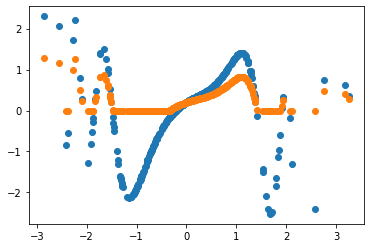

weight[0] shape:  torch.Size([20, 400])
bias[0] shape:  torch.Size([20, 1])
Relu Params[0]:  0.009999973008629584
BN gamma[0]:  1.5536595326946203
BN beta[0]:  -7461.116251366032
weight[1] shape:  torch.Size([10, 20])
bias[1] shape:  torch.Size([10, 1])
Relu Params[1]:  -9.9553530015232e-08
BN gamma[1]:  -0.9910294075847725
BN beta[1]:  -55.21421654115341
weight[2] shape:  torch.Size([5, 10])
bias[2] shape:  torch.Size([5, 1])
Relu Params[2]:  0.01
BN gamma[2]:  0.9999999988290565
BN beta[2]:  -0.03492053859001166
weight[3] shape:  torch.Size([400, 5])
bias[3] shape:  torch.Size([400, 1])
Relu Params[3]:  0.01000068816056092
BN gamma[3]:  1.0000006881602725
BN beta[3]:  -3.2648570178475096e-07


In [61]:
if __name__ == '__main__':
    layers = (20, 10, 5, 400)
    aFuncs = ('PRelu', 'PRelu', 'cos', 'PRelu')
    batchSize = 10
    nn1 = DNN(layers, aFuncs)
    # 所有input全部变型成 m x 1 的形状
    testInput = torch.randn((20, 20), dtype=DTYPE['f64'], device=DEVICE[DEVICE_CHOICE])
    testInput = testInput.view(-1, 1)
    targetY = nn1.batchNorm(5*torch.sin(testInput**3) + 2*torch.cos(2*testInput-1) - torch.tanh(testInput), 0)
    # 生成权重和偏移
    nn1.genParam(testInput)
    nn1.printShape()
    # 训练
    nn1.train(testInput, targetY, nanInvestigate=0, epoch=1000)
    # 预测
    estimateY = nn1.predict(testInput)
    
    plt.scatter(testInput.cpu().numpy().flatten(), targetY.cpu().numpy().flatten())
    plt.scatter(testInput.cpu().numpy().flatten(), estimateY.cpu().numpy().flatten())
    plt.show()
    nn1.printShape()

In [103]:
nn1.layers['A']

[tensor([[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]], device='cuda:0', dtype=torch.float64),
 tensor([[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan]], device='cuda:0', dtype=torch.float64),
 tensor([[nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
         [nan],
        

In [112]:
nn2 = DNN(layers, aFuncs)
nn2.readParams('d:\\nanInvest_41.pt')
print(nn2.biases)

[tensor([[-5.0529e+275],
        [-5.0529e+275],
        [-5.0529e+275],
        [-5.0529e+275],
        [-5.0529e+275],
        [-5.0529e+275],
        [-5.0529e+275],
        [-5.0529e+275],
        [-5.0529e+275],
        [-5.0529e+275]], device='cuda:0', dtype=torch.float64), tensor([[5.3672],
        [5.3672],
        [5.3672],
        [5.3672],
        [5.3672],
        [5.3672],
        [5.3672],
        [5.3672],
        [5.3672],
        [5.3672]], device='cuda:0', dtype=torch.float64), tensor([[-1.2032e-02],
        [-3.6203e-04],
        [ 1.3286e-01],
        [ 8.2065e-01],
        [ 3.5820e-01],
        [ 4.0628e-01],
        [-1.7814e-03],
        [ 9.0331e-01],
        [-8.3471e-03],
        [-2.0779e-02],
        [ 4.1217e-01],
        [ 7.1294e-01],
        [-1.9788e-02],
        [-2.5701e-04],
        [ 8.4488e-01],
        [ 3.0465e-01],
        [-7.4479e-02],
        [ 3.3996e-03],
        [-2.8695e-02],
        [-6.4443e-02],
        [ 5.4960e-01],
        [-1.3078